Data Assignment 1

POS Tagging

Ningyu Han

# Introduction

The data I obtained is from Kaggle and provides a summary of customer ticket information for technology devices. It's crucial to understand the urgency of a ticket to ensure technicians address the issues promptly. This is particularly important for Technical Communication Firms, Software, and App Developers, etc. From the company's perspective, this approach allows for more efficient resource allocation. For instance, assigning more employees to handle high-urgency tickets. At the same time, companies can gauge the performance of their technological devices or apps and identify the most pressing issues. Access to this information enables companies to tackle problems and implement improvements. On the customer side, promptly addressing high-urgency tickets boosts satisfaction and can lead to higher retention rates.

This paper aims to evaluate the POS (Part of Speech) tags in SpaCy, focusing specifically on adjectives, adverbs, nouns, and verbs within ticket texts. We will undertake actions to uncover any correlation between these four POS tags and the urgency levels of the tickets. Once a relationship between the tags and ticket urgency be identified, it could enable us to predict the urgency of future incoming tickets. This predictive insight would aid in proactive resource planning.
<br>
<br>
The driving **research question** for this study is:
- What are the relationships between POS tags for nouns, verbs, adjectives, and adverbs, and the urgency of tickets?
<br>

**Null Hypothesis**: There is no difference in the frequency of a given part of speech (ADJ, ADV, NOUN, VERB) between low urgency and high urgency tickets.

# Data (Methods)

As mentioned before, the data is from Kaggle and here is the link: <br>https://www.kaggle.com/code/aniketg11/support-tickets-classification/notebook <br>

The dataset contains details on more than 48,000 tickets, covering aspects like the ticket's title, its body text, the type of ticket, how urgent it is, etc. The only place you'll find missing values is in the "title" column. I've decided to fill in these blanks with "no title" to keep things tidy. In addition, I merged the "title" and "body" columns into one, calling it "title_body," to make analyzing the ticket content a bit easier, since both title and body are key parts of a ticket.

The dataset, with its over 48,000 observations, is quite too large to run NLP analysis. To work around this, I randomly selected 3,000 rows and popped them into a new dataframe named 'df_sampled'.

The "urgency" column, which is key, has values ranging from 0 to 3 that indicates how urgent each ticket is. I grouped urgency levels 0 and 1 into a 'low urgency' category, and levels 2 and 3 into a 'high urgency' category. This is because I'm planning to run a t-test later on.

In [1]:
import pandas as pd
from google.colab import drive
import os
import spacy

In [2]:
drive.mount('/content/drive')

os.getcwd()

os.listdir()

os.chdir("/content/drive/MyDrive/Colab Notebooks/NLP/data")

os.listdir()

Mounted at /content/drive


['all_tickets.csv',
 'reading_600_texts.csv',
 'reading_600_texts_metadata_only.csv',
 'Moving beyond classic readability formulas.pdf',
 'all_excerpts',
 'reading_data_morphemes.csv',
 'writing_data_w_meta_data.csv',
 'nrc.csv',
 'CRAPII_practice',
 'ticket_data.csv',
 'CLEAR_corpus_final.xlsx',
 'readability_model_checkpoints',
 'readability_model_1',
 'reading_600_texts_trf_readability.csv',
 'data_ticket.csv']

In [3]:
# %%capture
# !apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
# !jupyter nbconvert --to pdf /content/drive/MyDrive/Colab\ Notebooks/NLP/Data_Assignment_1.ipynb
# # !jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/NLP/Data_Assignment_1.ipynb

In [4]:
# Read my data
df = pd.read_csv('data_ticket.csv', encoding = "ISO-8859-1")
# Combine the title and body column
df['title_body'] = df.apply(lambda row: 'no title: ' + row['body'] if pd.isnull(row['title']) or row['title'].strip() == '' else row['title'] + ': ' + row['body'], axis=1)
df['title_body'] = df['title_body'].str.lower()
df.head()


,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,title_body
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,2,4,no title: hi since recruiter lead permission a...
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,2,4,connection with icon: icon dear please setup i...
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,1,4,work experience user: work experience user hi ...
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4,requesting for meeting: requesting meeting hi ...
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,1,4,reset passwords for external accounts: re expi...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48549 entries, 0 to 48548
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             47837 non-null  object
 1   body              48549 non-null  object
 2   ticket_type       48549 non-null  int64 
 3   category          48549 non-null  int64 
 4   sub_category1     48549 non-null  int64 
 5   sub_category2     48549 non-null  int64 
 6   business_service  48549 non-null  int64 
 7   urgency           48549 non-null  int64 
 8   impact            48549 non-null  int64 
 9   title_body        48549 non-null  object
dtypes: int64(7), object(3)
memory usage: 3.7+ MB


In [6]:
distinct_values = df['urgency'].unique()
distinct_values

array([2, 1, 3, 0])

In [7]:
df_sampled = df.sample(n=3000, random_state=1)

In [8]:
# Make definitions for high urgency and low urgency
df_sampled['urgency_group'] = df_sampled['urgency'].apply(lambda x: 'High' if x in [2, 3] else 'Low')
df_sampled.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,title_body,urgency_group
832,new purchase po,purchase po dear purchased please log allocati...,1,5,13,7,32,3,4,new purchase po: purchase po dear purchased pl...,High
25705,replace with regular laptop,thursday december pm replace regular dear ask ...,1,5,13,7,32,3,4,replace with regular laptop: thursday december...,High
22008,new starter,friday february pm assistants starter testing ...,1,4,2,94,40,3,4,new starter: friday february pm assistants sta...,High
27630,need laptop encrypting,encrypting,1,0,0,0,32,3,4,need laptop encrypting: encrypting,High
28505,can we add colleague to please,tuesday october pm add colleague please hello ...,1,4,1,7,39,2,4,can we add colleague to please: tuesday octobe...,High


# Linguistic and NLP Analysis

I used the spaCy package in my study to figure out the Part of Speech (POS) tags for each piece of ticket text in the "title_body" column. Specifically, I looked at nouns (NOUN), verbs (VERB), adjectives (ADJ), and adverbs (ADV), following the Universal Dependencies tag set.

After counting each of these tags, I normalized these counts by the total number of words in each ticket text. This way, the comparisons are fair, no matter how long a ticket text is, because usually, the more words there are, the more tags you get. This approach helps analyze how the linguistic features in ticket texts relates to how urgent they are.

We then add these normalized figures to the pandas dataframe, setting the stage for further statistical analysis.



In [9]:
# safe divide function to stop zero counts from causing problems. This is zero counts for number of words
def safe_divide(a, b): #function calls two arguments. Here it will be a POS count and number of words
    if b != 0: #
        return a/b
    else:
        return 0

In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
from collections import Counter

# Initialize lists
nw_final, adj_final, adv_final, noun_final, verb_final = [], [], [], [], []

# Process each row in the dataframe
for text in df_sampled['title_body'].astype(str):  # Ensure the text is in string format
    # Use spaCy pipline
    doc = nlp(text)

    # Count the POS tags and non-punctuation tokens
    pos_counts = Counter(token.pos_ for token in doc if not token.is_punct and not token.pos_ == "SPACE")
    # Total number of non-punctuation tokens
    total_words = sum(pos_counts.values())

    # Calculate and append normalized counts and append to lists
    nw_final.append(total_words)
    adj_final.append(safe_divide(pos_counts['ADJ'], total_words))
    adv_final.append(safe_divide(pos_counts['ADV'], total_words))
    noun_final.append(safe_divide(pos_counts['NOUN'], total_words))
    verb_final.append(safe_divide(pos_counts['VERB'], total_words))

print(nw_final[:5])
print(adj_final[:5])


[35, 18, 32, 4, 22]
[0.11428571428571428, 0.2777777777777778, 0.09375, 0.0, 0.0]


In [12]:
#add the variables to the dataframe

df_sampled['NW'] = nw_final
df_sampled['ADJ'] = adj_final
df_sampled['ADV'] = adv_final
df_sampled['NOUN'] = noun_final
df_sampled['VERB'] = verb_final

# Reorder the columns
new_column_order = ['title_body', 'NW', 'ADJ', 'ADV', 'NOUN', 'VERB', 'urgency', 'impact','urgency_group']
df_sampled = df_sampled[new_column_order]
df_sampled.head()

,title_body,NW,ADJ,ADV,NOUN,VERB,urgency,impact,urgency_group
832,new purchase po: purchase po dear purchased pl...,35,0.114286,0.000000,0.514286,0.228571,3,4,High
25705,replace with regular laptop: thursday december...,18,0.277778,0.000000,0.333333,0.166667,3,4,High
22008,new starter: friday february pm assistants sta...,32,0.093750,0.000000,0.375000,0.250000,3,4,High
27630,need laptop encrypting: encrypting,4,0.000000,0.000000,0.500000,0.500000,3,4,High
28505,can we add colleague to please: tuesday octobe...,22,0.000000,0.045455,0.181818,0.318182,2,4,High


# Statistical Analysis

In [13]:
from scipy.stats import ttest_ind

# Define the T-test function
def perform_ttest(pos_tag):
    low_urgency = df_sampled[df_sampled['urgency_group'] == 'Low'][pos_tag]
    high_urgency = df_sampled[df_sampled['urgency_group'] == 'High'][pos_tag]

    t_stat, p_val = ttest_ind(low_urgency, high_urgency, equal_var=False)
    return t_stat, p_val

# Perform T-tests for each POS tag and print the results
for tag in ['ADJ', 'ADV', 'NOUN', 'VERB']:
    t_stat, p_val = perform_ttest(tag)
    print(f"T-test for {tag}: T-statistic = {t_stat:.4f}, P-value = {p_val:.10f}")

T-test for ADJ: T-statistic = -2.7039, P-value = 0.0069063850
T-test for ADV: T-statistic = 1.5233, P-value = 0.1278472198
T-test for NOUN: T-statistic = -4.0842, P-value = 0.0000460248
T-test for VERB: T-statistic = 1.1892, P-value = 0.2344762753


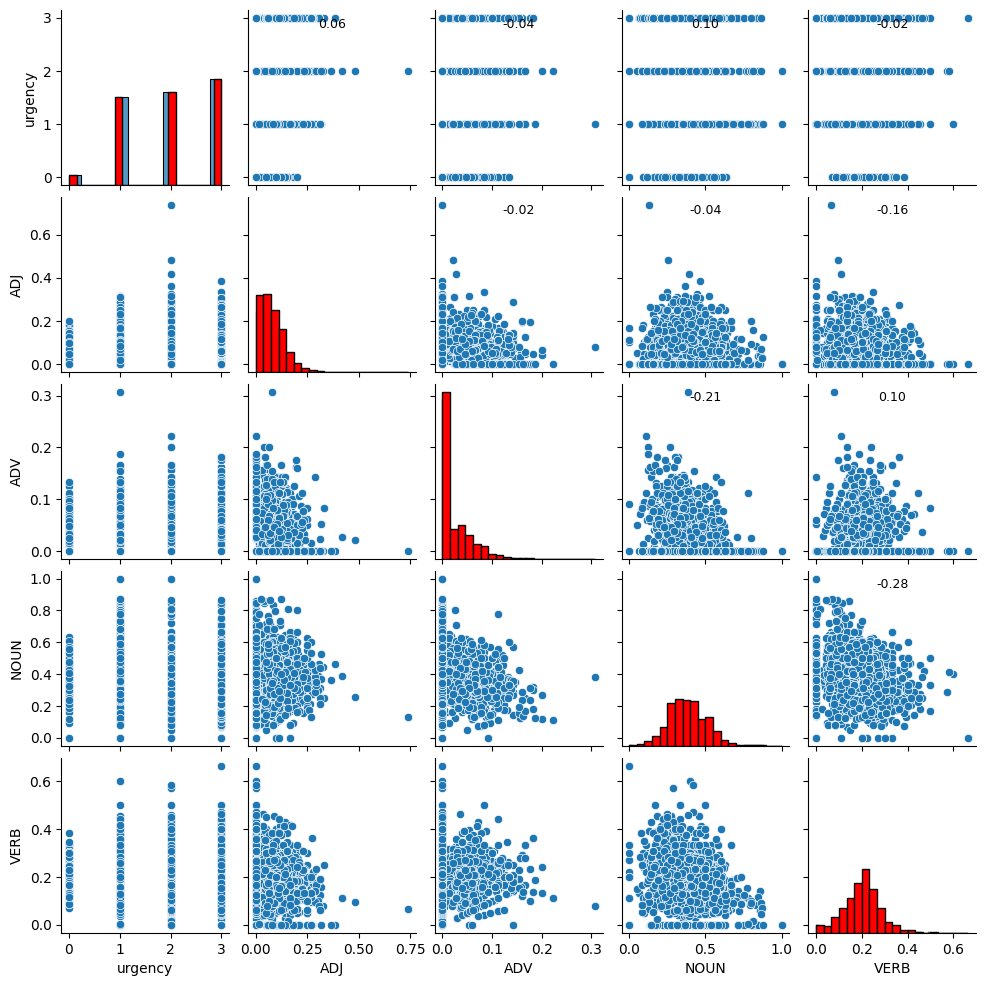

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract desired columns
data = df_sampled[['urgency', 'ADJ', 'ADV', 'NOUN', 'VERB']]

# Create the pair plot
pair_plot = sns.pairplot(data, diag_kind='hist', height = 2, aspect = 1)

# Customize the histograms
for ax in pair_plot.diag_axes:
    ax.hist(data[ax.get_xlabel()], bins=20, color='red', edgecolor='k')

# Calculate correlation coefficients on the upper side of the matrix
for i in range(len(data.columns)):
    for j in range(len(data.columns)):
        if i < j:
            pearson_corr = data.corr().iloc[i, j]
            # Customize the following line to format the correlation coefficient
            pair_plot.axes[i, j].annotate(f"{pearson_corr:.2f}", (0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=9)

plt.show()

# Result and Summary

**From t-test outputs:** <br>

**ADJ:** we got a t-test score of -2.7039, suggesting they're less common in high urgency tickets. Since the p-value is under the usual threshold of 0.05, we reject the null hypothesis for adjectives.

**ADV:** the t-test score is 1.5233, hinting that they're more frequent in high urgency tickets. With the p-value being above 0.05, we don't reject the null hypothesis for adverbs.

**NOUN:** we got a t-test score of -4.0842, indicating they're less frequent in high urgency tickets. Again, the p-value is below 0.05, we reject the null hypothesis for nouns.

**VERB:** the t-test score is 1.1892, which means they pop up more in high urgency tickets. The p-value is above 0.05, so the null hypothesis for verbs is not rejected.

<br>

**From the pair plot:** <br>

The urgency of tickets and POS tags have a weak linear relationship.

Nouns (0.1) and adjectives (0.06) show a positive correlation, suggesting that higher urgency tickets tend to have more nouns and adjectives.

Conversely, there is a negative relationship with verbs (-0.02) and adverbs (-0.04), indicating higher urgency tickets may have fewer verbs and adverbs.
<br>
<br>

**In summary,** the null hypotheses for both nouns and adjectives are rejected after the t-test. This evidence indicates there is a difference in how adjectives and nouns are used between high and low urgency tickets.